# MAST30034 Assignment2

## 2.Preprocessing



In [1]:
import pandas as pd
import warnings
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 Input Dataset
We focus on 2018 the whole year Dataset (Yellow car) 

In [ ]:
# Read the whole year Data set
yellow_01 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-01.csv")
yellow_02 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-02.csv")
yellow_03 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-03.csv")
yellow_04 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-04.csv")
yellow_05 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-05.csv")
yellow_06 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-06.csv")
yellow_07 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-07.csv")
yellow_08 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-08.csv")
yellow_09 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-09.csv")
yellow_10 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-10.csv")
yellow_11 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-11.csv")
yellow_12 = pd.read_csv("E:/Uni/MAST30034/Data/yellow_tripdata_2018-12.csv")

### 2.2 Combine all the data

In [ ]:
# Combine all data together
data  = yellow_01.append(yellow_02).append(yellow_03).append(yellow_04).append(yellow_05).append(yellow_06)
data  = data.append(yellow_07).append(yellow_08).append(yellow_09).append(yellow_10).append(yellow_11).append(yellow_12)

In [ ]:
data.reset_index().to_feather('2018_data.feather')

### 3.Missing Value Detect

In [3]:
data.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

### 4.Feature engineering

"VendorID", "RatecodeID", "store_and_fwd_flag", "extra","mta_tax","improvement_surcharge","tolls_amount" are not the feature we focus on. We firstly drop them inorder to reduce the complexity

In [ ]:
data = data.drop(["VendorID", "RatecodeID", "store_and_fwd_flag", "extra","mta_tax","improvement_surcharge","tolls_amount"], axis='columns')

We want to focus on the pickup time (in hours) and duration, beacuse the time may influence the traffic information, we think the traffic may have any relationship with tip amount

#### 4.1 Time and Duration

In [ ]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
#droped_sample['Month'] = droped_sample['tpep_pickup_datetime'].dt.month
data['Date'] = data['tpep_pickup_datetime'] .dt.normalize()
data['Druation'] = (data['tpep_dropoff_datetime']-data['tpep_pickup_datetime'])
data['Druation'] = data['Druation']/ np.timedelta64(1, 'm')

data["Time_h"] = data["tpep_pickup_datetime"].dt.hour

data

We also want to focus on the date, we classfy them into holiday, weekend and workday,we believe that different data may also affect the tip amount.                
Note, the holiday we use the USFederalHolidayCalendar

#### 4.2 Date(Holiday，Weekend and Workday)

In [ ]:
cal = calendar()
holidays = cal.holidays(start="2018-01-01", end="2018-12-31")
#droped_sample['Holiday'] = pd.to_datetime(droped_sample['Holiday'])
data['Holiday'] = data['Date'].isin(holidays)
data['Week'] = data['Date'].dt.dayofweek
data.loc[data['Week'] > 5, "Type"] = "Weekend"
data.loc[data['Week'] <= 5, "Type"] = "Workday"
data.loc[data['Holiday'] == True, "Type"] = "Holiday"
data = data.drop(["Holiday", "Week"], axis='columns')
data['Date'] = data['Date'].astype(str)
data

In [ ]:
data.to_feather('2018_data_feature_engineering.feather')

In [ ]:
data = pd.read_feather("2018_data_feature_engineering.feather")

### 5.Data Cleaning
After feature enging we found there are other abnormal data, thus we decide do feature eng first, then do the data cleaning

#### 5.1 Remove Noisy Data

In [ ]:
# restricted data in the vaild time [Sep 2018]
cleaned_data = data[(data["tpep_pickup_datetime"]<"2018-12-31 23:59:59") & (data["tpep_pickup_datetime"]>"2018-01-01 00:00:00")]
cleaned_data = cleaned_data[(cleaned_data["tpep_dropoff_datetime"]<"2018-12-31 23:59:59") & (cleaned_data["tpep_dropoff_datetime"]>"2018-01-01 00:00:00")]

In [ ]:
# remove passenger == 0 and passenger > 7 since the maximum number of adult passenger is 5,but adults are allowed to bring kids, we
# assume the maximum number of passenger is 7 (include kids)
# https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page
cleaned_data = cleaned_data[(cleaned_data["passenger_count"] > 0)&(data["passenger_count"] < 7 )]

In [ ]:
# trip_distance == 0 and  trip_distance <200
# we found there are some extrem long distence trip, they are not reasonable, so we make a restriction on 200 miles.
cleaned_data = cleaned_data[(cleaned_data["trip_distance"] > 0)&(data["trip_distance"] < 200 )]

In [ ]:
# 1 < Druation < 120
# The duation are measured in minutes, some of data have the duration less than 1, we seen them as mis recorded data
# We also make a restriction on 120 mins.
cleaned_data = cleaned_data[(cleaned_data["Druation"] > 1) & (cleaned_data["Druation"] < 120)]

In [ ]:
# We only focus on the data with tips recoreded 
# So we only keep the data with Credit card payment_type
cleaned_data = cleaned_data[(cleaned_data["payment_type"] == 1)]

In [ ]:
# fare payment > 2.5
# The initial value of fare amount is 2.5, so we only keep the data larger than or equal to 2.5
cleaned_data = cleaned_data[(cleaned_data["fare_amount"] >= 2.5)]     

In [ ]:
# total payment > 2.5
# As we mentioned, the initial value of fare amount is 2.5.
# The total amount could only be lagrer than or equal to the fare amount
# Therefore we only keep the total amount which is larger than or equal to 2.5
cleaned_data = cleaned_data[(cleaned_data["total_amount"] >= 2.5)]  

In [ ]:
cleaned_data = cleaned_data.reset_index(drop=True)
cleaned_data.to_feather('2018_cleaned.feather')

In [2]:
cleaned_data = pd.read_feather("2018_cleaned.feather")

### 5.2 Outliers Detect and Remove

In [3]:
cleaned_data.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,Druation,Time_h
count,7.013822e+07,7.013822e+07,7.013822e+07,7.013822e+07,70138220.0,7.013822e+07,7.013822e+07,7.013822e+07,7.013822e+07,7.013822e+07
mean,1.596283e+00,3.078846e+00,1.637424e+02,1.620944e+02,1.0,1.331804e+01,2.676624e+00,1.752350e+01,1.485269e+01,1.387206e+01
std,1.232064e+00,3.854872e+00,6.595406e+01,7.008887e+01,0.0,1.130875e+01,2.621047e+00,1.455749e+01,1.163988e+01,6.165144e+00
min,1.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.0,2.500000e+00,0.000000e+00,3.300000e+00,1.016667e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.140000e+02,1.130000e+02,1.0,6.500000e+00,1.320000e+00,9.350000e+00,7.016667e+00,9.000000e+00
50%,1.000000e+00,1.700000e+00,1.620000e+02,1.620000e+02,1.0,9.500000e+00,2.000000e+00,1.285000e+01,1.161667e+01,1.500000e+01
75%,2.000000e+00,3.190000e+00,2.330000e+02,2.340000e+02,1.0,1.500000e+01,3.000000e+00,1.896000e+01,1.891667e+01,1.900000e+01
max,6.000000e+00,9.329000e+02,2.650000e+02,2.650000e+02,1.0,7.620000e+02,9.459700e+02,9.527700e+02,1.199833e+02,2.300000e+01


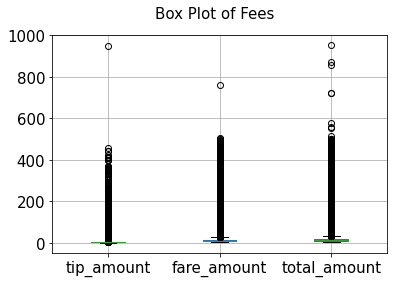

In [4]:
# initial view of fees
amount = ["tip_amount","fare_amount","total_amount"]

amount_boxplot = cleaned_data.boxplot(column=amount, fontsize=15,figsize=(6,4))
fig = amount_boxplot.get_figure()

fig.suptitle('Box Plot of Fees',fontsize=15)
plt.show()
fig.savefig("Box Plot of Fees.png")

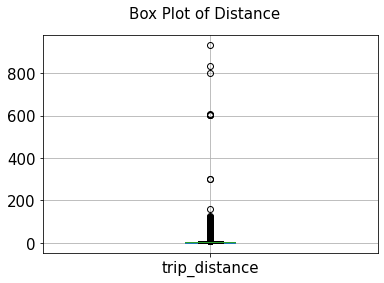

In [5]:
# initial view of distance
distance = ["trip_distance"]

distance = cleaned_data.boxplot(column=distance, fontsize=15,figsize=(6,4))
fig = distance.get_figure()

fig.suptitle('Box Plot of Distance',fontsize=15)
plt.show()
fig.savefig("Box Plot of Distance.png")

We decide to use Interquartile Rule to find Outliers and remove them

In [ ]:
Q1 = cleaned_data[["tip_amount","fare_amount","total_amount","trip_distance"]].quantile(0.25)
Q3 = cleaned_data[["tip_amount","fare_amount","total_amount","trip_distance"]].quantile(0.75)
IQR = Q3 - Q1

cleaned= cleaned_data[~((cleaned_data[["tip_amount","fare_amount","total_amount","trip_distance"]]< (Q1 - 3 * IQR)) |(cleaned_data[["tip_amount","fare_amount","total_amount","trip_distance"]]> (Q3 + 3 * IQR))).any(axis=1)]

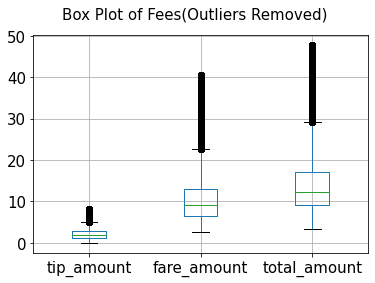

In [7]:
# Plot the Outliers removed plot
amount = ["tip_amount","fare_amount","total_amount"]

amount_boxplot = cleaned.boxplot(column=amount, fontsize=15,figsize=(6,4))
fig = amount_boxplot.get_figure()

fig.suptitle('Box Plot of Fees(Outliers Removed)',fontsize=15)
plt.show()
fig.savefig("Box Plot of Fees(Outliers Removed).png")

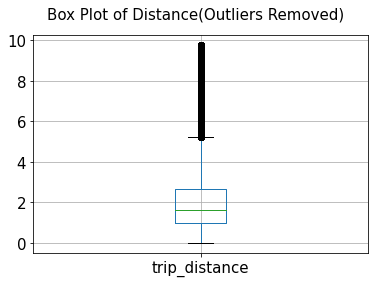

In [8]:
distance = ["trip_distance"]

distance = cleaned.boxplot(column=distance, fontsize=15,figsize=(6,4))
fig = distance.get_figure()

fig.suptitle('Box Plot of Distance(Outliers Removed)',fontsize=15)
plt.show()
fig.savefig("Box Plot of Distance(Outliers Removed).png")

In [ ]:
cleaned.reset_index(drop=True).to_feather('2018_cleaned_without_outliers.feather')

### 6. Adding extra Data set
#### 6.1 Weather(Wind, precipitate, snow, snow deep, temp	and Weather Type)

In [2]:
cleaned = pd.read_feather("2018_cleaned_without_outliers.feather")
weather = pd.read_feather("cleaned_2018_NewYork_weather.feather")

In [3]:
cleaned = cleaned.drop(["payment_type"], axis='columns')
cleaned_data = pd.merge(cleaned, weather, left_on='Date', right_on='DATE')

In [ ]:
cleaned_data

### 7. Tip type modify

The are some records with 0 tip amount, we classify them to a new group

In [11]:
cleaned_data['Tip'] = np.where(cleaned_data["tip_amount"]> 0, 1, 0)

In [12]:
cleaned_data.to_feather("2018_finished.feather")

### 8.Sampling 
The whole year dataset is gigantic, it's hard for my pc to handle such huge dataset.
Therefore we decide to sample 1% of the whole dataset to represent the whole dataset.

In [13]:
sample = cleaned_data.sample(frac=0.01, replace=True, random_state=30034)
sample = sample.sort_values(by=['tpep_pickup_datetime']).reset_index(drop=True)

In [14]:
sample

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,Date,...,Time_h,Type,DATE,AWND,PRCP,SNOW,SNWD,TAVG,Weather Type,Tip
0,2018-01-01 00:00:25,2018-01-01 00:06:08,1,1.36,43,237,6.5,2.34,10.14,2018-01-01,...,0,Holiday,2018-01-01,7.83,0.00,0.0,0.0,-10.555556,N,1
1,2018-01-01 00:03:46,2018-01-01 00:08:42,1,0.70,148,79,5.0,1.25,7.55,2018-01-01,...,0,Holiday,2018-01-01,7.83,0.00,0.0,0.0,-10.555556,N,1
2,2018-01-01 00:05:09,2018-01-01 00:09:03,3,0.90,263,43,5.5,1.35,8.15,2018-01-01,...,0,Holiday,2018-01-01,7.83,0.00,0.0,0.0,-10.555556,N,1
3,2018-01-01 00:08:03,2018-01-01 00:16:01,2,1.45,107,148,7.5,1.76,10.56,2018-01-01,...,0,Holiday,2018-01-01,7.83,0.00,0.0,0.0,-10.555556,N,1
4,2018-01-01 00:09:20,2018-01-01 00:39:38,1,2.60,162,48,19.0,4.05,24.35,2018-01-01,...,0,Holiday,2018-01-01,7.83,0.00,0.0,0.0,-10.555556,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648293,2018-12-31 23:34:09,2018-12-31 23:40:50,1,0.69,249,249,6.0,1.46,8.76,2018-12-31,...,23,Workday,2018-12-31,0.00,1.02,0.0,0.0,5.555556,Y,1
648294,2018-12-31 23:35:31,2018-12-31 23:55:56,4,3.80,48,158,16.0,3.45,20.75,2018-12-31,...,23,Workday,2018-12-31,0.00,1.02,0.0,0.0,5.555556,Y,1
648295,2018-12-31 23:36:21,2018-12-31 23:44:45,1,2.40,142,151,9.0,2.50,12.80,2018-12-31,...,23,Workday,2018-12-31,0.00,1.02,0.0,0.0,5.555556,Y,1
648296,2018-12-31 23:44:40,2018-12-31 23:52:33,1,0.71,142,48,6.5,5.00,12.80,2018-12-31,...,23,Workday,2018-12-31,0.00,1.02,0.0,0.0,5.555556,Y,1


In [15]:
sample.to_csv('2018_sample.csv')
sample.to_feather('2018_sample.feather')